In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pickle
import matplotlib.pyplot as plt
import numpy as np
import laboratorio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calibración de SA para el problema de la mochila

## Introducción

En el laboratorio anterior implementamos el algoritmo de Simulated Annealing (SA) para resolver el problema de la mochila. En particular se implementó la siguiente función de aceptación para las propuestas

$$
\alpha(x^*|x_t) = \min \left [ 1, \exp \left ( \frac{U(x^*) - U(x_t)}{T}\right) \right]
$$

donde $x_t$ es la solución de la iteración anterior, $x^*$ es la solución propuesta, $U(x)= \sum_{j=1}^m v_j z_j$ es la función de utilidad y $T$ es la temperatura. La temperatura influye fuertemente en la aceptación de propuestas. 

- Temperaturas muy bajas dificultan la aceptación de propuestas "no tan buenas", haciendo que el algoritmo converja rápidamente a una solución y explore poco. 
- Temperaturas muy altas hacen que el algoritmo acepte siempre toda propuesta aunque esta sea muy mala. El algoritmo explora mucho sin memoría de cuales han sido las mejores soluciones

En general el algoritmo ideal debería explorar el espacio en una fase inicial y luego explotar las mejores soluciones obtenidas en una segunda fase. Es por esto que en SA se utilizan reglas dinámicas de tipo

$$
T_i = T_0 \beta^i
$$

con $\beta < 1$, para seleccionar la temperatura. La temperatura parte en un valor $T_0$ alto y converje a $0$ luego de una cierta cantidad de iteraciones. Este número de iteraciones está dictado por el factor de disminución $\beta$



## Actividad

En lo que sigue considere el problema `knapsack2.pkl`

Utilicen SA con la regla dinámica anterior para resolver el problema de la mochila. El objetivo es calibrar el tiempo de mezcla, $T_0$ y $\beta$ en función de la utilidad alcanzanda en convergencia (iteración final de la cadena) y el número de iteraciones necesarias para converger.

En cada experimento utilice al menos 5 cadenas para calcular el promedio y desviación estándar de la utilidad final. 


- Explore empíricamente la influencia de cada hiper-parámetro y proponga iterativamente combinaciones de los mismos
- Muestre una tabla con las métricas (utilidad en convergencia y número de iteraciones) en función de los hiper-parámetros explorados
- Realice observaciones y discusiones sobre sus resultados

NOTA: No es necesario modificar `laboratorio.py`


/media/heart/Cofre/uach/24° Semestre/Simulacion/student-info274-lab4-simulion/laboratorio.py:50: RuntimeWarning: overflow encountered in exp
  alpha = np.amin([1, np.exp((U_new - U)/T)])


Utilidad en convergencia 13014.6000 +- 346.6846


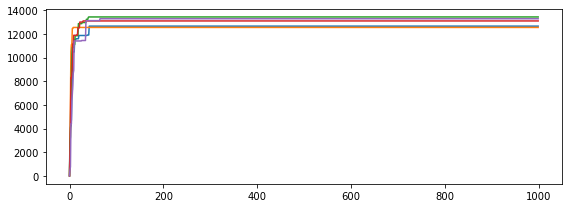

In [8]:
with open("data/knapsack2.pkl", "rb") as f:
    config = pickle.load(f)

mix_time = 1000
beta = 0.9
T0 = 1e+2

utility_trace = np.zeros(shape=(5, mix_time))
final_Us = []

for i in range(utility_trace.shape[0]):
    utility_trace[i, :], best_x, best_U = laboratorio.simulated_annealing(mix_time, config, T0, beta)
    final_Us.append(utility_trace[i, -1])
    

print(f"Utilidad en convergencia {np.mean(final_Us):0.4f} +- {np.std(final_Us):0.4f}")

fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
for trace in utility_trace:
    ax.plot(trace)
    

In [3]:
config

{'C': 10356,
 'v': array([  39,   93,  159,  240,  274,  493,  588,  752, 1025, 1324, 1588,
        1826, 1936, 2045, 2287, 2486, 2818, 2850, 3072, 3219, 3499, 3596,
        3620, 4067, 4432], dtype=int64),
 'w': array([   5,   42,   84,  126,  133,  309,  368,  502,  761, 1020, 1283,
        1517, 1584, 1656, 1865, 2031, 2320, 2349, 2553, 2667, 2929, 3024,
        3047, 3452, 3790], dtype=int64)}

Utilidad en convergencia 12080.0000 +- 512.0180


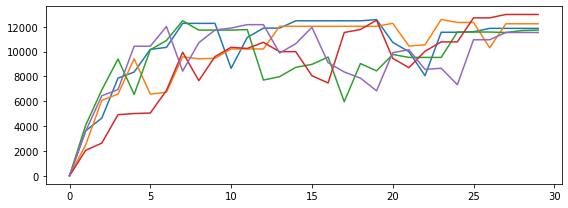

In [9]:
mix_time = 30
beta = 0.4
T0 = 1e+14

utility_trace = np.zeros(shape=(5, mix_time))
final_Us = []

for i in range(utility_trace.shape[0]):
    utility_trace[i, :], best_x, best_U = laboratorio.simulated_annealing(mix_time, config, T0, beta)
    final_Us.append(utility_trace[i, -1])
    

print(f"Utilidad en convergencia {np.mean(final_Us):0.4f} +- {np.std(final_Us):0.4f}")

fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
for trace in utility_trace:
    ax.plot(trace)

In [10]:
mx_time = list(range(5,70,15))
bta = list(np.linspace(0.0,0.999999,num=len(mx_time)))
T_0 = [pow(10,x) for x in range(len(mx_time))] 

In [12]:
def autocorrelation(theta_trace):
    thetas_norm = (theta_trace-np.mean(theta_trace))/np.std(theta_trace)
    rho = np.correlate(thetas_norm, 
                       thetas_norm, mode='full')
    return rho[len(rho) // 2:]/len(theta_trace)

def neff(rho):
    T = np.where(rho < 0.)[0][0]
    return len(rho)/(1 + 2*np.sum(rho[:T]))

def gelman_rubin(traces):
    J = len(traces) # Cantidad de trazas
    N = len(traces[0]) # Largo de las trazas
    chain_mean = np.zeros(shape=(J, ))
    chain_var = np.zeros(shape=(J, ))
    for i, trace in enumerate(traces):
        chain_mean[i] = np.mean(trace)
        chain_var[i] = np.sum((trace - chain_mean[i])**2)/(N-1)
    total_mean = np.mean(np.concatenate(traces))    
    B = np.sum((chain_mean - total_mean)**2)*N/(J-1)
    W = np.mean(chain_var)
    return (N-1)/N + B/(W*N)

##Muestras
def muestras(arr1,arr2):
    nf={}
    for i in range(len(arr1)):
        nf[arr1[i]]= []
        for trace in arr2[i]:
            nf[arr1[i]].append(neff(autocorrelation(trace)))
    return nf
##Para los graficos
def graficos(par,par2,nom_par):
    fig, ax = plt.subplots(len(par),2,figsize=(14, 17), tight_layout=True)
    for i in range(len(par)):
        for trace in par2[i]:
            ax[i,0].set_title("Traza en "+nom_par+str(par[i]))
            ax[i,0].plot(trace)
            ax[i,1].set_title("Autocorrelacion en "+str(par[i]))
            ax[i,1].plot(autocorrelation(trace))

# Variación de Mix Time

/media/heart/Cofre/uach/24° Semestre/Simulacion/student-info274-lab4-simulion/laboratorio.py:50: RuntimeWarning: overflow encountered in exp
  alpha = np.amin([1, np.exp((U_new - U)/T)])


En el mix_time 5 se tiene 1.2991  como el mejor numero de muestras efectivas
En el mix_time 20 se tiene 2.4742  como el mejor numero de muestras efectivas
En el mix_time 35 se tiene 2.8272  como el mejor numero de muestras efectivas
En el mix_time 50 se tiene 4.3181  como el mejor numero de muestras efectivas
En el mix_time 65 se tiene 6.0219  como el mejor numero de muestras efectivas


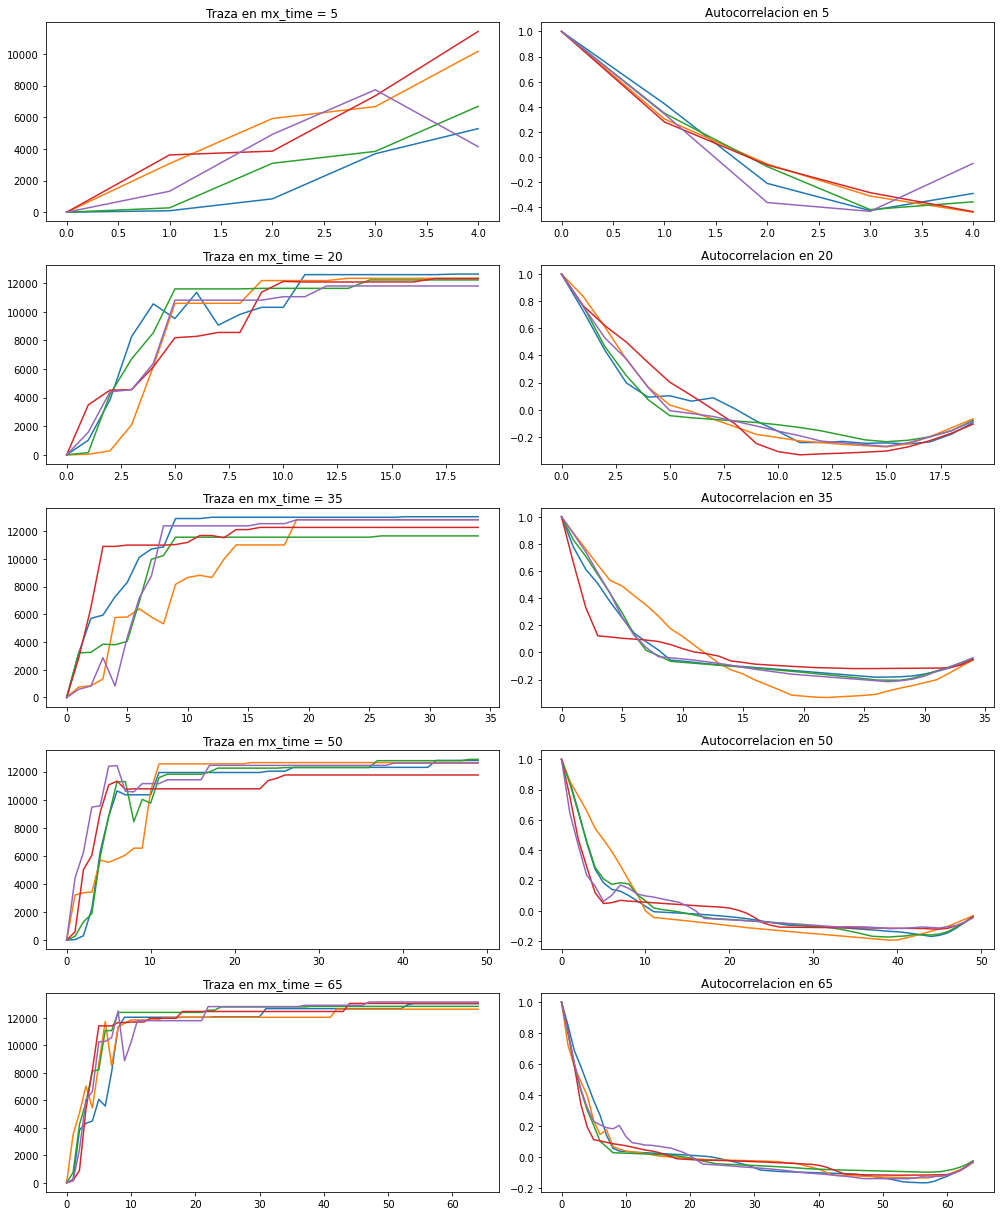

In [13]:
arr_mx_tm=[]
b=0.4
t=1e+7
for mx in mx_time:
    utility_trace = np.zeros(shape=(5, mx))
    for i in range(utility_trace.shape[0]):
        utility_trace[i, :], best_x, best_U = laboratorio.simulated_annealing(mx, config, t, b)
    arr_mx_tm.append(utility_trace)

nf = muestras(mx_time,arr_mx_tm)
for a in mx_time:
    print(f"En el mix_time {a} se tiene {min(nf[a]):0.4f}  como el mejor numero de muestras efectivas")
graficos(mx_time,arr_mx_tm,'mx_time = ')

# Variación de Beta

/media/heart/Cofre/uach/24° Semestre/Simulacion/student-info274-lab4-simulion/laboratorio.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = np.amin([1, np.exp((U_new - U)/T)])
/media/heart/Cofre/uach/24° Semestre/Simulacion/student-info274-lab4-simulion/laboratorio.py:50: RuntimeWarning: overflow encountered in exp
  alpha = np.amin([1, np.exp((U_new - U)/T)])


En el Beta 0.0 se tiene 5.3327  como el mejor numero de muestras efectivas
En el Beta 0.24999975 se tiene 4.6074  como el mejor numero de muestras efectivas
En el Beta 0.4999995 se tiene 5.8205  como el mejor numero de muestras efectivas
En el Beta 0.74999925 se tiene 4.6838  como el mejor numero de muestras efectivas
En el Beta 0.999999 se tiene 6.8298  como el mejor numero de muestras efectivas


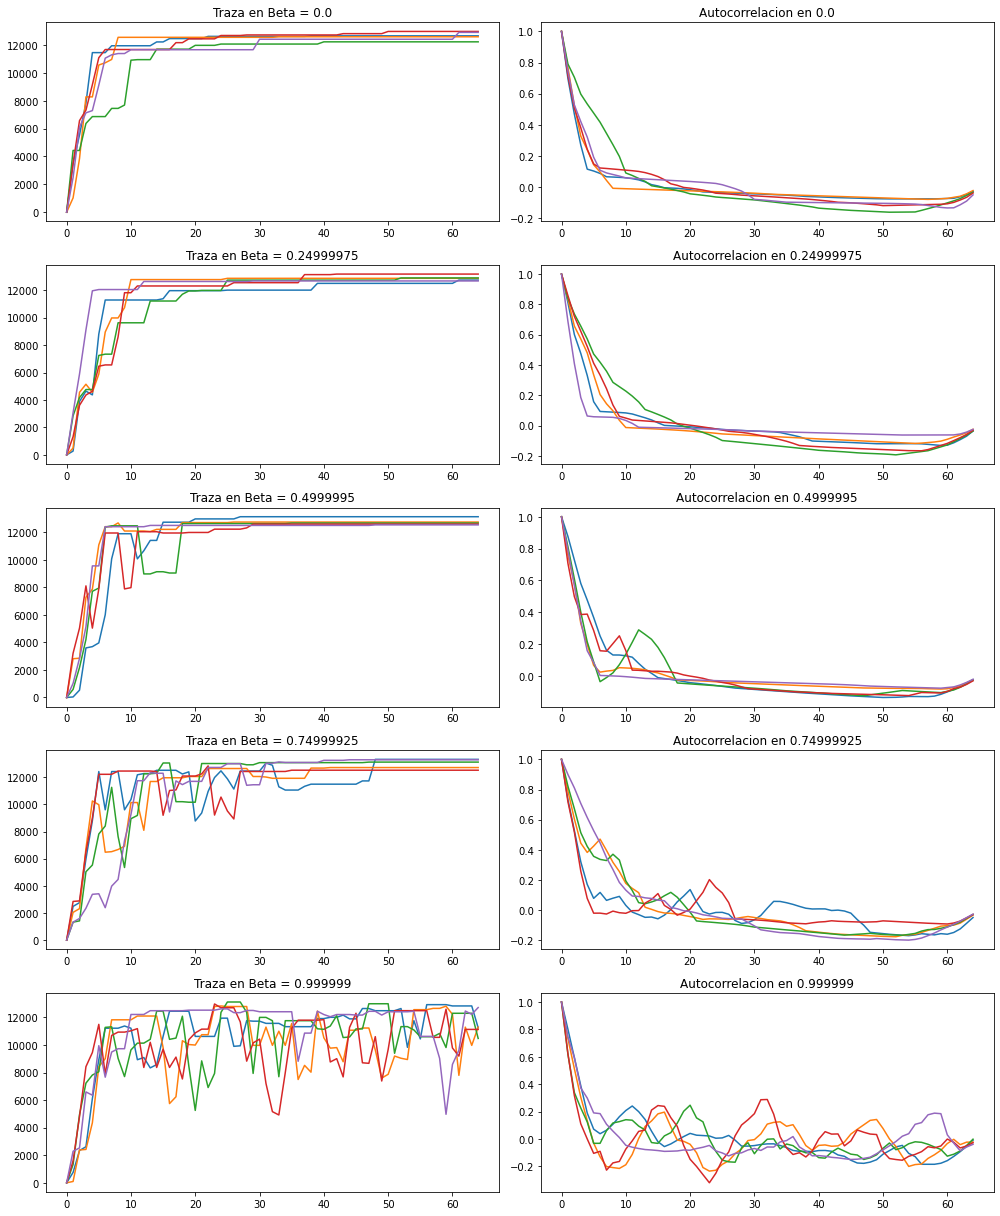

In [14]:
mx=65
t=1e+7
traza=[]
for b in bta:
    utility_trace = np.zeros(shape=(5, mx))
    for i in range(utility_trace.shape[0]):
        utility_trace[i, :], best_x, best_U = laboratorio.simulated_annealing(mx, config, t, b)
    traza.append(utility_trace)
nf=muestras(bta,traza)
for a in bta:
    print(f"En el Beta {a} se tiene {min(nf[a]):0.4f}  como el mejor numero de muestras efectivas")
graficos(bta,traza,'Beta = ')

# Variación de T°

/media/heart/Cofre/uach/24° Semestre/Simulacion/student-info274-lab4-simulion/laboratorio.py:50: RuntimeWarning: overflow encountered in exp
  alpha = np.amin([1, np.exp((U_new - U)/T)])


En el Beta 1 se tiene 5.2424  como el mejor numero de muestras efectivas
En el Beta 10 se tiene 4.7363  como el mejor numero de muestras efectivas
En el Beta 100 se tiene 5.4679  como el mejor numero de muestras efectivas
En el Beta 1000 se tiene 5.5514  como el mejor numero de muestras efectivas
En el Beta 10000 se tiene 5.6212  como el mejor numero de muestras efectivas


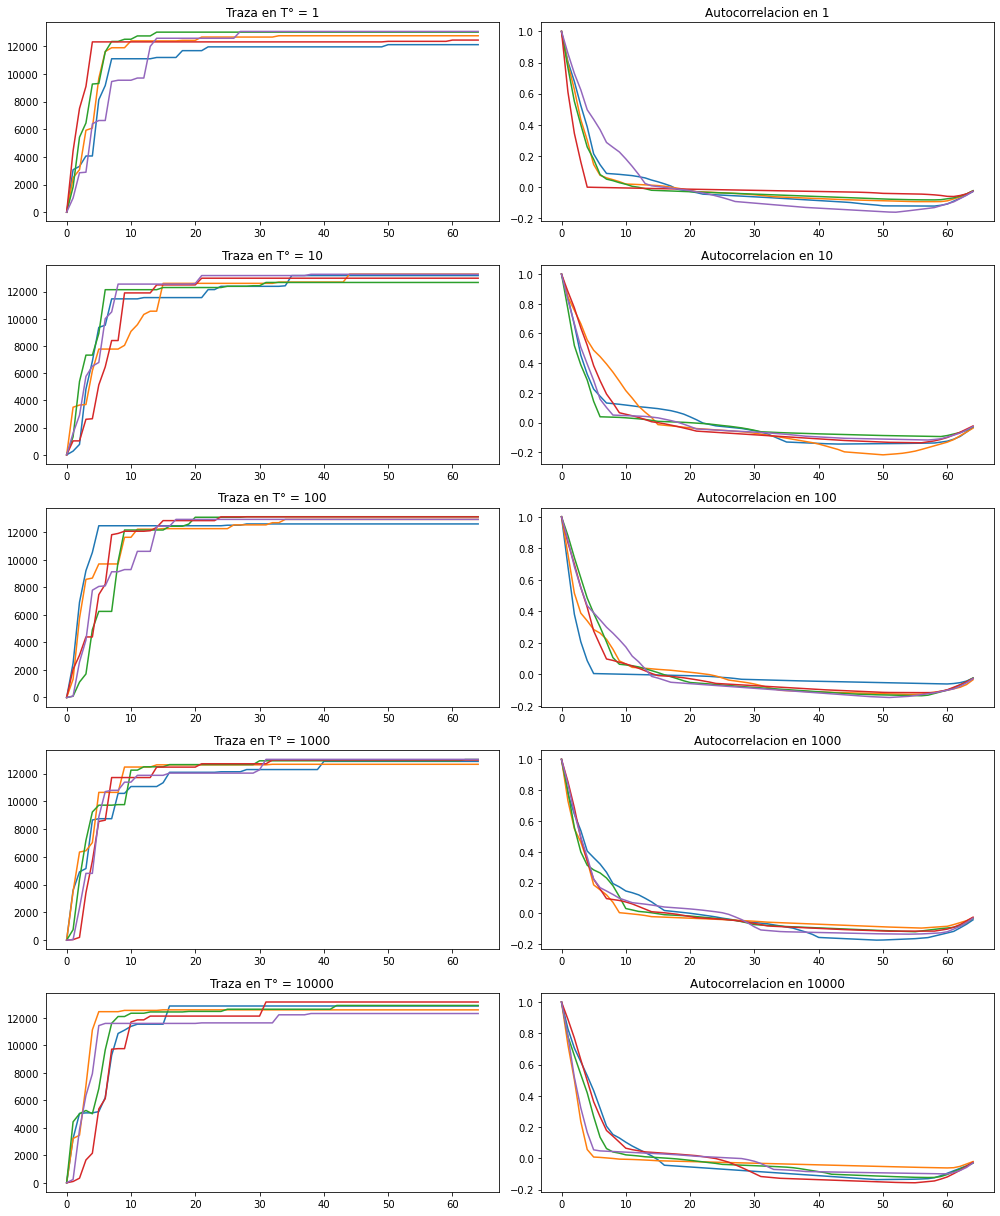

In [15]:
mx=65
b=bta[2]
traza=[]

for t in T_0:
    utility_trace = np.zeros(shape=(5, mx))
    for i in range(utility_trace.shape[0]):
        utility_trace[i, :], best_x, best_U = laboratorio.simulated_annealing(mx, config, t, b)
    traza.append(utility_trace)

nf= muestras(T_0,traza)
for a in T_0:
    print(f"En el Beta {a} se tiene {min(nf[a]):0.4f}  como el mejor numero de muestras efectivas")
graficos(T_0,traza,'T° = ')  

# Tabla de datos con Hiper parámetros

In [17]:
#mezclado
#Coleccion de datos mezclados trazas[Mix_ time][beta][temperatura]
def mezclados():
    print(f"TABLA DE DATOS")
    trz = {}
    for mx in mx_time:
        trz[mx] = {}
        for b in bta:
            trz[mx][b] = {}
            for t in T_0:
                trz[mx][b][t]=[]
                utility_trace = np.zeros(shape=(5, mx))
                final_Us = []
                for i in range(utility_trace.shape[0]):
                    utility_trace[i, :], best_x, best_U = laboratorio.simulated_annealing(mx, config, t, b)
                    final_Us.append(utility_trace[i, -1])
                for a in utility_trace:
                    print(f"Mix Time: {mx} | Beta: {b} | Traza Utilidad: {a}")
mezclados()

TABLA DE DATOS
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0.  274. 3346. 3505. 3598.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0. 2287. 4113. 7733. 7973.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [    0.  2850.  5668. 10100. 10100.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0. 1025. 2349. 5167. 5407.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [    0.  1936.  1975.  6042. 10474.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0. 2287. 5883. 6042. 7868.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0. 1588. 4074. 6892. 7051.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0.  159. 3658. 3898. 6185.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0.  274.  367. 1691. 1691.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0. 3596. 5883. 6471. 9289.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0.  240.  992. 2316. 5936.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [   0. 1936. 3762. 6981. 7020.]
Mix Time: 5 | Beta: 0.0 | Traza Utilidad: [    0.   274.  3894.  6966. 11398.]
Mix Time

# Comentarios finales.



Para un mixim time es necesario que éste esté en aumento pero no más de los 100, debido que permite a los datos poder ajustarse para lograr la convergencia, ya que una vez que éste parámetro logra sobre pasar las 100 unidades, la convergencia es efectiva y estable a partir de las 35 iteraciones.

Por otro lado el parámetro Beta, es necesario que sea cercano a 0 debido que permite una mejor estabilidad en las trazas para los ajustes respectivos a partir de las 25 iteraciones. Se recomienda que el parámetro del Beta sea entre [0 - 0.3][u].
Con una T° de 1e+7.

Para el parámetro de temperatura, este es necesario que sea bajo ya que permite ajustarse de mejor forma a los datos a medida que las iteraciones aumentan, logrando una convergencia mas estable en las trazas. Un intervalo adecuado es entre[0-10][u] entregando una estabilidad y convergencia de los datos a partir de las 15 - 20 iteraciones aprox.


Estos resultados son a base de las experimentaciones demostradas por cada proceso de variación, y en cuales se logra ver alguna tendencia por cada dato registrado de forma aproximada.